In [1]:
from heeps.util.img_processing import resize_cube, resize_img, crop_img
from heeps.util.freq_decomp import conv_kernel, spatial
from scipy.interpolate import interp2d,RectBivariateSpline, griddata
from heeps.pupil.create_petal import create_petal
import numpy
import numpy as np
import matplotlib.pyplot as plt
import time
import os.path
import multiprocessing as mpro
from functools import partial
from sys import platform
%matplotlib inline

In [2]:
def zoomWithMissingData(data, newSize,
                        method='linear',
                        non_valid_value=numpy.nan):
    '''
    Zoom 2-dimensional or 3D arrays using griddata interpolation.
    This allows interpolation over unstructured data, e.g. interpolating values
    inside a pupil but excluding everything outside.
    See also DM.CustomShapes.

    Note that it can be time consuming, particularly on 3D data

    Parameters
    ----------
    data : ndArray
        2d or 3d array. If 3d array, interpolate by slices of the first dim.
    newSize : tuple
        2 value for the new array (or new slices) size.
    method: str
        'linear', 'cubic', 'nearest'
    non_valid_value: float
        typically, NaN or 0. value in the array that are not valid for the
        interpolation.

    Returns
    -------
    arr : ndarray
        of dimension (newSize[0], newSize[1]) or
        (data.shape[0], newSize[0], newSize[1])
    '''
    if len(data.shape) == 3:
        arr = data[0, :, :]
    else:
        assert len(data.shape) == 2
        arr = data

    Nx = arr.shape[0]
    Ny = arr.shape[1]
    coordX = (numpy.arange(Nx) - Nx / 2. + 0.5) / (Nx / 2.)
    coordY = (numpy.arange(Ny) - Ny / 2. + 0.5) / (Ny / 2.)
    Nx = newSize[0]
    Ny = newSize[1]
    ncoordX = (numpy.arange(Nx) - Nx / 2. + 0.5) / (Nx / 2.)
    ncoordY = (numpy.arange(Ny) - Ny / 2. + 0.5) / (Ny / 2.)

    x, y = numpy.meshgrid(coordX, coordY)
    xnew, ynew = numpy.meshgrid(ncoordX, ncoordY)

    if len(data.shape) == 2:
        idx = ~(arr == non_valid_value)
        znew = griddata((x[idx], y[idx]), arr[idx], (xnew, ynew),
                        method=method)
        return znew
    elif len(data.shape) == 3:
        narr = numpy.zeros((data.shape[0], newSize[0], newSize[1]))
        for i in range(data.shape[0]):
            arr = data[i, :, :]
            idx = ~(arr == non_valid_value)
            znew = griddata((x[idx], y[idx]), arr[idx], (xnew, ynew),
                            method=method)
            narr[i, :, :] = znew
        return narr
#--------------------------------------------------#

# Load c-basic raw data

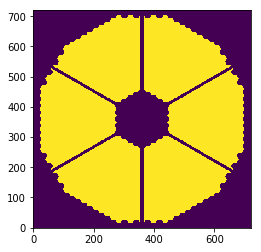

In [3]:
nimg = 720
#folder = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v2_2021-02-18'
#folder = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v1_2020-11-30'
folder = '/mnt/disk4tb/METIS/heeps_analysis/input_files/wavefront/scao_petal_piston/cbasic_v1_2020-11-30'
mask = np.float32(fits.getdata(os.path.join(folder, 'Telescope_Pupil.fits')))
mask = crop_img(mask, nimg)
mask = np.rot90(mask)
plt.imshow(mask, origin=True);

data piston (nm) = 1801.4716
data rms (nm) = 116.93555


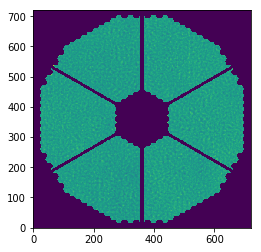

In [4]:
data = np.float32(fits.getdata(os.path.join(folder, 'Residual_phase_screen_2101ms.fits')))
data = crop_img(data, nimg)
data = np.rot90(data) * 1e3        # rotate, convert to nanometers
data[mask==0] = 0
print('data piston (nm) = %s\ndata rms (nm) = %s'%(np.mean(data[mask!=0]), np.std(data[mask!=0])))
plt.imshow(data, origin=True);

### remove frame piston

In [5]:
data -= np.mean(data[mask!=0])
data[mask==0] = 0
print('data piston (nm) = %s\ndata rms (nm) = %s'%(np.mean(data[mask!=0]), np.std(data[mask!=0])))

data piston (nm) = 0.0002272726
data rms (nm) = 116.93555


### calculate petal pistons

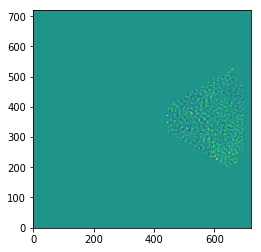

In [6]:
npetals = 6
petals = np.array([create_petal(x, npetals, nimg) for x in range(npetals)])
data_petals = data*petals
plt.imshow(data_petals[0], origin=True);

In [7]:
masked_petals = np.array([data_petals[x][data_petals[x]!=0] for x in range(npetals)])
for petal in masked_petals:
    print('petal piston (nm) = %s ; petal rms (nm) = %s'%(np.mean(petal), np.std(petal)))

petal piston (nm) = 21.993607 ; petal rms (nm) = 118.32676
petal piston (nm) = 7.6754103 ; petal rms (nm) = 112.62345
petal piston (nm) = -20.418915 ; petal rms (nm) = 113.43365
petal piston (nm) = 5.443414 ; petal rms (nm) = 115.68831
petal piston (nm) = -29.420332 ; petal rms (nm) = 116.8172
petal piston (nm) = 14.713904 ; petal rms (nm) = 115.71301


# Resize with skimage (currently in HEEPS)

In [8]:
npupil = 285
petals_res = np.float32([create_petal(x, npetals, npupil) for x in range(npetals)])
data_res_petals = petals_res*resize_img(data, npupil)
masked_petals = np.array([data_res_petals[x][data_res_petals[x]!=0] for x in range(npetals)])
for petal in masked_petals:
    print('petal piston (nm) = %s ; petal rms (nm) = %s'%(np.mean(petal), np.std(petal)))
data_res_petals.shape

petal piston (nm) = 20.18367 ; petal rms (nm) = 94.12751
petal piston (nm) = 7.070539 ; petal rms (nm) = 89.01941
petal piston (nm) = -18.91746 ; petal rms (nm) = 89.529816
petal piston (nm) = 5.0617557 ; petal rms (nm) = 90.460526
petal piston (nm) = -27.170889 ; petal rms (nm) = 93.095505
petal piston (nm) = 13.668022 ; petal rms (nm) = 92.50651


(6, 285, 285)

### same test on first frame from CM13 old cube

In [9]:
frame_CM13 = petals_res*fits.getdata(os.path.join(folder, 'frame_CM13.fits'))*1e9
masked_petals = np.array([frame_CM13[x][frame_CM13[x]!=0] for x in range(npetals)])
for petal in masked_petals:
    print('petal piston (nm) = %s ; petal rms (nm) = %s'%(np.nanmean(petal), np.nanstd(petal)))
frame_CM13.shape

petal piston (nm) = 20.183529 ; petal rms (nm) = 94.12751
petal piston (nm) = 7.0703974 ; petal rms (nm) = 89.01941
petal piston (nm) = -18.9176 ; petal rms (nm) = 89.529816
petal piston (nm) = 5.0616155 ; petal rms (nm) = 90.460526
petal piston (nm) = -27.17103 ; petal rms (nm) = 93.095505
petal piston (nm) = 13.667881 ; petal rms (nm) = 92.50651


(6, 285, 285)

### visualize resized pupil with this method

duration (s) = 0.10459256172180176


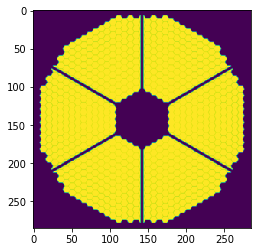

In [10]:
t0 = time.time()
#pupil = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/heeps_analysis/input_files/pupil/ELT_fullM1.fits')
pupil = fits.getdata('/mnt/disk4tb/METIS/heeps_analysis/input_files/pupil/ELT_fullM1.fits')
pupil_res = resize_img(pupil, npupil)
plt.imshow(pupil_res)
print('duration (s) = %s'%(time.time() - t0))

# Resize with scipy (Gilles' alternative method)

In [11]:
data_gox_petals = petals_res*zoomWithMissingData(data, [npupil,npupil], method='nearest', non_valid_value=np.nan)
masked_petals = np.array([data_gox_petals[x][data_gox_petals[x]!=0] for x in range(npetals)])
for petal in masked_petals:
    print('petal piston (nm) = %s ; petal rms (nm) = %s'%(np.mean(petal), np.std(petal)))
data_gox_petals.shape

petal piston (nm) = 21.739162 ; petal rms (nm) = 118.2782
petal piston (nm) = 8.175823 ; petal rms (nm) = 113.051285
petal piston (nm) = -20.312895 ; petal rms (nm) = 114.32351
petal piston (nm) = 5.8650613 ; petal rms (nm) = 115.26579
petal piston (nm) = -29.29221 ; petal rms (nm) = 117.25961
petal piston (nm) = 15.025115 ; petal rms (nm) = 116.10016


(6, 285, 285)

### visualize resized pupil with this method

duration (s) = 5.502218961715698


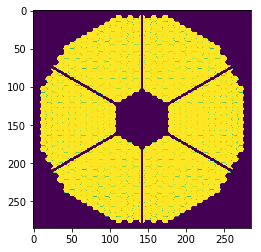

In [12]:
t0 = time.time()
pupil_gox = zoomWithMissingData(pupil, [npupil,npupil], method='nearest', non_valid_value=np.nan)
plt.imshow(pupil_gox)
print('duration (s) = %s'%(time.time() - t0))

# PSD functions

In [13]:
def calc_one_cpp(data, nimg, cpp, verbose=False):
    _, LSF, HSF = spatial(data, conv_kernel(nimg, cpp), verbose=False)
    return LSF, HSF

In [14]:
def calc_multi_cpp(data, nimg, case, cpps, cpu_count=None, verbose=False):
    filename = '%s_%s.fits'
    if not os.path.isfile(filename%('LSFs', case)):
        filename = os.path.join(folder, filename)
    try:
        LSFs = fits.getdata(filename%('LSFs', case))
        HSFs = fits.getdata(filename%('HSFs', case))
        print('   Load LSFs from %s'%filename%('LSFs', case))
        print('   Load HSFs from %s'%filename%('HSFs', case))
    except FileNotFoundError: # run simulation
        t0 = time.time()
        if cpu_count != 1 and platform in ['linux', 'linux2', 'darwin']:
            if cpu_count == None:
                cpu_count = mpro.cpu_count() - 1
            print('   %s: spatial freq simulation starts, using %s cores'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), cpu_count))
            p = mpro.Pool(cpu_count)
            func = partial(calc_one_cpp, data, nimg, verbose=verbose)
            res = np.array(p.starmap(func, zip(cpps)))
            LSFs = res[:,0]
            HSFs = res[:,1]
            p.close()
            p.join()
        else:
            print('   %s: spatial freq simulation starts, using 1 core'\
                %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
            print('cpp = ', end='')
            for i,cpp in enumerate(cpps):
                print(np.round(cpp, 2), end=', ')
                LFS, HFS = calc_one_cpp(data, nimg, cpp, verbose=verbose)
                LSFs = LFS if i == 0 else np.dstack((LSFs.T, LFS.T)).T
                HSFs = HFS if i == 0 else np.dstack((HSFs.T, HFS.T)).T
            print('\n')
        print('   %s: finished, elapsed %.3f seconds'\
            %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), time.time() - t0))
        fits.writeto(filename%('LSFs', case), np.float32(LSFs), overwrite=True)
        fits.writeto(filename%('HSFs', case), np.float32(HSFs), overwrite=True)
    LSFs_rms = np.array([np.std(x[x!=0]) for x in LSFs])
    HSFs_rms = np.array([np.std(x[x!=0]) for x in HSFs])
    dcpp = np.append(cpps[0], cpps[1:] - cpps[:-1])
    drms = np.append(LSFs_rms[0], LSFs_rms[1:] - LSFs_rms[:-1])
    PSD = drms**2/dcpp
    print('LSF (nm rms) = %s'%np.round(LSFs_rms, 2))
    print('HSF (nm rms) = %s'%np.round(HSFs_rms, 2))
    print('PSD = %s'%np.round(PSD, 2))
    return PSD

### raw frame PSD

In [15]:
#cpps = np.logspace(0, 1.1, 3)
cpps = np.logspace(0, 1.6, 40)
data_raw = data_petals[0][nimg//4:nimg//4*3, nimg//2:]
#data_raw = data
print('data_raw.shape = (%s, %s)'%data_raw.shape)
PSD_raw = calc_multi_cpp(data_raw, 720, 'raw', cpps, cpu_count=None, verbose=True)

data_raw.shape = (360, 360)
   2021-03-30 08:36:39: spatial freq simulation starts, using 55 cores
   2021-03-30 08:38:48: finished, elapsed 128.911 seconds
LSF (nm rms) = [ 0.    0.    0.04  0.24  0.75  1.66  2.81  4.02  5.11  6.3   7.52  8.67
  9.88 10.95 12.09 13.05 14.01 14.86 15.68 16.4  17.   17.58 18.07 18.69
 19.07 19.6  20.01 20.29 20.71 21.02 21.4  21.82 22.33 23.11 23.65 24.25
 24.86 25.86 26.44 26.44]
HSF (nm rms) = [118.33 118.33 118.33 118.33 118.31 118.24 118.09 117.92 117.78 117.65
 117.55 117.47 117.36 117.29 117.25 117.18 117.12 117.06 116.96 116.9
 116.83 116.71 116.71 116.64 116.45 116.38 116.62 116.76 116.6  116.1
 115.39 114.89 115.24 116.8  117.92 119.08 120.05 120.25 118.78 118.78]
PSD = [0.   0.   0.01 0.34 1.96 5.77 8.36 8.34 6.16 6.79 6.43 5.13 5.28 3.72
 3.84 2.48 2.23 1.6  1.38 0.96 0.6  0.51 0.34 0.48 0.16 0.29 0.16 0.07
 0.14 0.07 0.09 0.11 0.14 0.3  0.13 0.15 0.14 0.34 0.1  0.  ]


### resized frame PSD (skimage)

In [16]:
data_skimg = data_res_petals[0][npupil//4:npupil//4*3, npupil//2:]
#data_skimg = resize_img(data, npupil)
print('data_skimg.shape = (%s, %s)'%data_skimg.shape)
PSD_skimg = calc_multi_cpp(data_skimg, 285, 'skimg', cpps, cpu_count=None, verbose=True)

data_skimg.shape = (142, 143)
   2021-03-30 08:38:50: spatial freq simulation starts, using 55 cores
   2021-03-30 08:39:45: finished, elapsed 55.618 seconds
LSF (nm rms) = [ 0.    0.    0.06  0.27  0.86  1.85  2.96  4.    5.12  6.21  7.24  8.35
  9.56 10.6  11.69 12.51 13.32 14.12 14.63 15.39 15.89 16.38 16.9  17.17
 17.73 18.02 18.31 18.63 18.98 19.39 19.89 20.45 21.15 21.15 22.25 22.25
 23.46 23.46 25.15 25.15]
HSF (nm rms) = [94.13 94.13 94.13 94.13 94.11 94.03 93.88 93.71 93.55 93.44 93.35 93.26
 93.16 93.09 93.06 93.   92.94 92.89 92.81 92.72 92.63 92.49 92.46 92.4
 92.1  92.06 92.18 92.34 92.27 91.79 90.98 90.57 91.63 91.63 94.12 94.12
 95.69 95.69 91.94 91.94]
PSD = [0.   0.   0.03 0.37 2.73 6.68 7.76 6.25 6.5  5.69 4.57 4.83 5.16 3.51
 3.53 1.81 1.62 1.41 0.53 1.09 0.41 0.37 0.37 0.09 0.36 0.09 0.08 0.09
 0.1  0.12 0.16 0.18 0.27 0.   0.54 0.   0.54 0.   0.88 0.  ]


### resized frame PSD (scipy)

In [17]:
data_gox = data_gox_petals[0][npupil//4:npupil//4*3, npupil//2:]
#data_gox = zoomWithMissingData(data, [npupil,npupil], method='nearest', non_valid_value=np.nan)
print('data_gox.shape = (%s, %s)'%data_gox.shape)
PSD_gox = calc_multi_cpp(data_gox, 285, 'gox', cpps, cpu_count=None, verbose=True)

data_gox.shape = (142, 143)
   2021-03-30 08:39:46: spatial freq simulation starts, using 55 cores
   2021-03-30 08:40:31: finished, elapsed 45.807 seconds
LSF (nm rms) = [ 0.    0.    0.04  0.23  0.74  1.7   2.88  4.    5.16  6.25  7.29  8.45
  9.7  10.77 11.94 12.88 13.83 14.78 15.39 16.33 16.95 17.57 18.22 18.55
 19.22 19.58 19.94 20.31 20.69 21.07 21.54 22.09 22.88 22.88 24.22 24.22
 25.82 25.82 27.79 27.79]
HSF (nm rms) = [118.28 118.28 118.28 118.28 118.26 118.17 118.03 117.87 117.73 117.62
 117.54 117.45 117.36 117.27 117.24 117.16 117.09 117.02 116.93 116.84
 116.76 116.63 116.64 116.6  116.35 116.32 116.45 116.63 116.64 116.21
 115.39 114.86 115.76 115.76 118.24 118.24 120.01 120.01 116.44 116.44]
PSD = [0.   0.   0.02 0.29 1.99 6.4  8.72 7.14 7.06 5.58 4.73 5.23 5.57 3.72
 4.04 2.42 2.18 2.02 0.76 1.62 0.66 0.58 0.59 0.14 0.52 0.13 0.13 0.12
 0.11 0.11 0.14 0.18 0.33 0.   0.8  0.   0.95 0.   1.19 0.  ]


# PSD figure

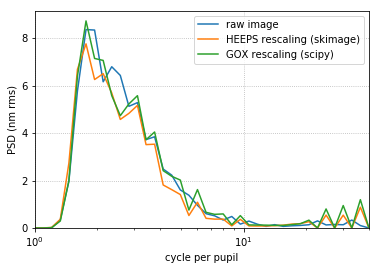

In [18]:
plt.plot(cpps, PSD_raw, label='raw image')
plt.plot(cpps, PSD_skimg, label='HEEPS rescaling (skimage)')
plt.plot(cpps, PSD_gox, label='GOX rescaling (scipy)')
plt.xscale('log')
plt.xlabel('cycle per pupil'), plt.ylabel('PSD (nm rms)')
plt.xlim(1,40), plt.ylim(bottom=0), plt.legend()
plt.grid(True, linestyle=':')
plt.savefig(os.path.join(folder, 'petal_PSD.png'), dpi=300, transparent=True);